# HALT: Hallucination Detection — End-to-End Experiments (GSM8K & StrategyQA)
**Google Colab Notebook**

**What this does**
- Loads GSM8K and StrategyQA via 🤗 Datasets
- Generates model outputs using either **OpenAI GPT-3.5/4.x** *(if you set your API key)* or a local **Hugging Face** fallback model
- Implements our **HALT** detector (Self-Consistency, Knowledge Verification, Confidence) + baselines
- Evaluates detection accuracy / precision / recall / F1
- Produces summary tables and CSVs

**Important**
- If you do **not** provide an OpenAI key, the notebook will use a small HF model and/or a pseudo-generator. This is OK for wiring/tests but *not* representative results.
- Replace any simulated runs with your true model outputs to obtain real numbers for the paper.


In [ ]:
#@title ⬇️ Setup: Install Dependencies
# !pip -q install datasets==2.20.0 transformers==4.44.2 accelerate==0.34.2   sentence-transformers==3.0.1 scikit-learn==1.5.1   wikipedia==1.4.0 wikipedia-api==0.6.0   torch==2.4.0 tqdm==4.66.5   matplotlib==3.9.2 pandas==2.2.2 numpy==1.26.4   openai==1.46.0
# !pip -q install transformers==4.44.2 sentence-transformers==3.0.1
!pip -q install wikipedia==1.4.0 wikipedia-api==0.6.0

  Preparing metadata (setup.py) ... done


In [ ]:
    # !pip uninstall transformers torchvision
    # !pip install transformers torchvision

In [ ]:
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.
google-genai 1.33.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [ ]:
#@title 🔑 Configure API Keys (Optional for OpenAI)
import os

# Enter your key here (or set in Colab: Runtime > Run all, then paste when prompted)
OPENAI_API_KEY = ""  #@param {type:"string"}
if OPENAI_API_KEY:
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

print("OpenAI configured?" , bool(os.environ.get("OPENAI_API_KEY")))

OpenAI configured? True


## Imports & Utility

In [ ]:
#@title 🧰 Imports
import os, re, math, json, random, time, string
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

# Embeddings for semantic clustering
from sentence_transformers import SentenceTransformer, util

import torch
import torchvision # Delayed import to avoid circular dependency
from datasets import load_dataset

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



# Wikipedia utilities
import wikipedia
import wikipediaapi

# Plotting
import matplotlib.pyplot as plt

# OpenAI (optional)
from openai import OpenAI
openai_client = None
if os.environ.get("OPENAI_API_KEY"):
    openai_client = OpenAI()

## Data Loading

In [ ]:
#@title 📚 Load GSM8K and StrategyQA (small subsets by default for speed)
# You can increase `MAX_SAMPLES_*` later for full runs.
MAX_SAMPLES_GSM8K = 30000  #@param {type:"integer"}
MAX_SAMPLES_STRAT = 30000   #@param {type:"integer"}

# GSM8K
gsm8k = load_dataset('openai/gsm8k', 'main')
# test split name is 'test' (1319 items); we'll use it
gsm8k_test = gsm8k['test']
if MAX_SAMPLES_GSM8K:
    gsm8k_test = gsm8k_test.select(range(min(MAX_SAMPLES_GSM8K, len(gsm8k_test))))

# StrategyQA
strategy = load_dataset('tasksource/strategy-qa')  # has 'train' split with labels
strategy_dev = strategy['train']  # Use train as dev for open evaluation
if MAX_SAMPLES_STRAT:
    strategy_dev = strategy_dev.select(range(min(MAX_SAMPLES_STRAT, len(strategy_dev))))

len_gsm = len(gsm8k_test)
len_str = len(strategy_dev)
len_gsm, len_str

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

strategyQA_train.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/2290 [00:00<?, ? examples/s]

(1319, 2290)

## Model Wrappers
We provide two paths:
- **OpenAI**: GPT-3.5/4.1-mini via API (requires key)
- **HF Fallback**: A small instruction model (quality not comparable; use only for infrastructure tests)

In [ ]:
#@title 🤖 Model Wrapper: OpenAI (GPT-3.5 / GPT-4.1-mini)
USE_OPENAI = bool(openai_client)
OPENAI_MODEL = "gpt-3.5-turbo"  #@param ["gpt-3.5-turbo","gpt-4o-mini","gpt-4o","gpt-4.1"]
MAX_TOKENS = 256  #@param {type:"integer"}
TEMPERATURE = 0.2  #@param {type:"number"}

SYSTEM_PROMPT = (
    "You are an assistant that answers carefully. Provide reasoning steps before the final answer."
)

def openai_generate(prompt: str, temperature: float = TEMPERATURE) -> Dict[str, Any]:
    assert openai_client is not None
    resp = openai_client.chat.completions.create(
        model=OPENAI_MODEL,
        temperature=temperature,
        messages=[{"role":"system","content":SYSTEM_PROMPT},
                  {"role":"user","content":prompt}],
        max_tokens=MAX_TOKENS,
        logprobs=True if OPENAI_MODEL.startswith("gpt-4") else False
    )
    msg = resp.choices[0].message
    text = msg.content
    # Note: logprobs only for some models; may be None
    logprobs = getattr(msg, 'logprobs', None)
    return {"text": text, "logprobs": logprobs}


In [ ]:
#@title 🐥 HF Fallback Generator (very small model)
from transformers import AutoModelForCausalLM, AutoTokenizer

HF_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # small; purely for plumbing
_device = "cuda" if torch.cuda.is_available() else "cpu"
_hf_tok = AutoTokenizer.from_pretrained(HF_MODEL)
_hf_model = AutoModelForCausalLM.from_pretrained(HF_MODEL, torch_dtype=torch.float16 if _device=="cuda" else torch.float32)
_hf_model.to(_device)

def hf_generate(prompt: str, temperature: float = 0.7, max_new_tokens: int = 256) -> Dict[str, Any]:
    inputs = _hf_tok(prompt, return_tensors="pt").to(_device)
    with torch.no_grad():
        out = _hf_model.generate(**inputs, do_sample=True, temperature=temperature,
                                 max_new_tokens=max_new_tokens, pad_token_id=_hf_tok.eos_token_id)
    text = _hf_tok.decode(out[0], skip_special_tokens=True)
    return {"text": text, "logprobs": None}


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
#@title 🔌 Unified generate()

def generate_answer(prompt: str, temperature: float = 0.2):
    if USE_OPENAI:
        return openai_generate(prompt, temperature)
    else:
        return hf_generate(prompt, max_new_tokens=256)


## Task Prompts

In [ ]:
#@title 🧪 Prompts for GSM8K and StrategyQA
GSM_PROMPT_TMPL = """
Solve the following math word problem step by step. Show your reasoning and end with a final numeric answer on a new line prefixed by 'Final Answer:'.

Problem: {q}
"""

STRAT_PROMPT_TMPL = """
Answer this yes/no question with brief reasoning. Provide your reasoning then a final answer as 'Final Answer: Yes' or 'Final Answer: No'.

Question: {q}
"""


## Generation (collecting model outputs)
*You can re-run to regenerate or cache to disk.*

In [ ]:
#@title ▶️ Generate Outputs (may take time; uses HF fallback without OpenAI key)
import json, os
from pathlib import Path

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

results = {"gsm8k": [], "strategyqa": []}

# GSM8K
for ex in tqdm(gsm8k_test, desc="GSM8K generation"):
    q = ex["question"]
    gold = ex["answer"]
    prompt = GSM_PROMPT_TMPL.format(q=q)
    gen = generate_answer(prompt)
    results["gsm8k"].append({"question": q, "gold": gold, "output": gen["text"], "logprobs": gen["logprobs"]})

# StrategyQA (use 'question' and 'answer' boolean)
for ex in tqdm(strategy_dev, desc="StrategyQA generation"):
    q = ex["question"]
    gold_bool = bool(ex["answer"])
    gold = "Yes" if gold_bool else "No"
    prompt = STRAT_PROMPT_TMPL.format(q=q)
    gen = generate_answer(prompt)
    results["strategyqa"].append({"question": q, "gold": gold, "output": gen["text"], "logprobs": gen["logprobs"]})

with open(OUT_DIR/"raw_generations.json", "w") as f:
    json.dump(results, f)

len(results["gsm8k"]), len(results["strategyqa"])

StrategyQA generation: 100%|██████████| 2290/2290 [1:04:42<00:00,  1.70s/it]


(1319, 2290)

## Parsing helpers
We need to extract the final answer (number or yes/no) and optionally the intermediate steps.

In [ ]:
#@title 🧩 Parsing Utilities
NUM_RE = re.compile(r"Final Answer:\s*([-+]?\d+(?:\.\d+)?)", re.IGNORECASE)
YN_RE  = re.compile(r"Final Answer:\s*(Yes|No)", re.IGNORECASE)

@dataclass
class Parsed:
    steps: List[str]
    final: Optional[str]


def parse_solution(text: str, task: str) -> Parsed:
    # crude step extraction: split lines before Final Answer
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    final_idx = None
    for i,l in enumerate(lines):
        if l.lower().startswith("final answer"):
            final_idx = i; break
    steps = lines[:final_idx] if final_idx is not None else lines
    # final
    final = None
    if task == 'gsm8k':
        m = NUM_RE.search(text)
        final = m.group(1) if m else None
    else:
        m = YN_RE.search(text)
        final = m.group(1).capitalize() if m else None
    return Parsed(steps=steps, final=final)


## HALT Components

In [ ]:
#@title ✅ Self-Consistency Analyzer (GSM8K math checks / StrategyQA sub-questions)
from math import isclose

# Very lightweight arithmetic check: extract simple operations from steps
OP_RE = re.compile(r"(\d+(?:\.\d+)?)\s*([+\-*/])\s*(\d+(?:\.\d+)?)\s*=\s*(\d+(?:\.\d+)?)")

# Simple sub-question templates for StrategyQA
SUBQ_TMPLS = [
    "Is the previous reasoning consistent with the final answer? Answer Yes or No only.",
    "Considering your reasoning, does it imply the same Yes/No conclusion? Answer Yes or No only."
]


def check_gsm_steps(steps: List[str]) -> float:
    if not steps: return 0.5
    checks, ok = 0, 0
    for s in steps:
        mo = OP_RE.search(s)
        if not mo:
            continue
        checks += 1
        a, op, b, rhs = mo.groups()
        a, b, rhs = float(a), float(b), float(rhs)
        val = None
        if op == '+': val = a+b
        elif op == '-': val = a-b
        elif op == '*': val = a*b
        elif op == '/':
            if b == 0: val = None
            else: val = a/b
        if val is not None and isclose(val, rhs, rel_tol=1e-6, abs_tol=1e-6):
            ok += 1
    if checks == 0:
        return 0.6  # neutral-ish
    return ok / checks


def subq_agreement(answer_text: str) -> float:
    # Ask 1-2 tiny meta-questions and expect Yes
    if not USE_OPENAI:
        # Fallback heuristic: neutral
        return 0.6
    agrees = 0
    total = 0
    for tmpl in SUBQ_TMPLS:
        total += 1
        resp = openai_generate(answer_text + "\n\n" + tmpl, temperature=0.0)
        m = re.search(r"\b(Yes|No)\b", resp["text"], re.I)
        if m and m.group(1).lower()=="yes":
            agrees += 1
    return agrees/total if total>0 else 0.5


def S_c(parsed: Parsed, task: str, answer_text: str) -> float:
    if task == 'gsm8k':
        return check_gsm_steps(parsed.steps)
    else:
        return subq_agreement(answer_text)


In [ ]:
#@title 🔎 Knowledge Verifier (targeted Wiki search + NLI entailment)
from transformers import AutoModelForSequenceClassification, AutoTokenizer

NLI_MODEL = "valhalla/distilbart-mnli-12-1"  # light NLI
_nli_tok = AutoTokenizer.from_pretrained(NLI_MODEL)
_nli = AutoModelForSequenceClassification.from_pretrained(NLI_MODEL).to(_device)

# Fix: Specify a user agent for wikipediaapi
wiki = wikipediaapi.Wikipedia('HALT_Colab_Notebook/1.0 (research purposes)', 'en')

CLAIM_RE = re.compile(r"([A-Z][a-zA-Z0-9\- ]+?\s(?:is|are|was|were|has|have)\s[^.]+\.)")

def harvest_claims(text: str, max_claims=3):
    sents = re.split(r"(?<=[.!?])\s+", text)
    claims = []
    for s in sents:
        m = CLAIM_RE.search(s)
        if m:
            claims.append(m.group(1))
        if len(claims)>=max_claims:
            break
    return claims


def wiki_snippet(query: str) -> Optional[str]:
    try:
        page = wiki.page(query.split()[0])
        if page.exists():
            return page.summary[:500]
    except Exception:
        return None
    return None

LABELS = {0: 'contradiction', 1: 'neutral', 2: 'entailment'}

def nli_score(premise: str, hypothesis: str) -> float:
    inputs = _nli_tok(premise, hypothesis, return_tensors='pt', truncation=True).to(_device)
    with torch.no_grad():
        logits = _nli(**inputs).logits[0].softmax(-1).detach().cpu().numpy()
    # return entailment probability minus contradiction probability
    return float(logits[2] - logits[0])


def S_v(answer_text: str) -> float:
    claims = harvest_claims(answer_text, max_claims=3)
    if not claims:
        return 0.6
    scores = []
    for c in claims:
        snip = wiki_snippet(c)
        if not snip:
            scores.append(0.0)
        else:
            scores.append(nli_score(snip, c))
    # Map from [-1,1] avg to [0,1]
    avg = np.mean(scores) if scores else 0.0
    return float((avg + 1.0)/2.0)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/890M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/890M [00:00<?, ?B/s]

In [ ]:
#@title 📉 Confidence Estimator (tail resampling entropy + optional logprobs)
EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
_emb = SentenceTransformer(EMB_MODEL, device=_device)

TAIL_PROMPT = "Rewrite only the final answer based on the reasoning above, preserving meaning."


def tail_variants(answer_text: str, k: int = 3) -> List[str]:
    if not USE_OPENAI:
        # heuristic: duplicate plus tiny noise
        base = answer_text.strip()
        return [base] + [base + f" (v{i})" for i in range(1,k)]
    outs = []
    for _ in range(k):
        resp = openai_generate(answer_text+"\n\n"+TAIL_PROMPT, temperature=1.0)
        outs.append(resp["text"])
    return outs


def semantic_entropy(texts: List[str]) -> float:
    if len(texts)<=1:
        return 0.0
    embs = _emb.encode(texts, convert_to_tensor=True, normalize_embeddings=True)
    sims = util.pytorch_cos_sim(embs, embs).cpu().numpy()
    # crude: treat 1-similarity as distance; entropy over mean distances
    dists = 1.0 - sims
    mean_d = dists.mean(axis=1)
    # Normalize to [0,1]
    m = float(np.clip((mean_d - mean_d.min()) / (mean_d.max() - mean_d.min() + 1e-9), 0, 1).mean())
    return m


def S_p(answer_obj: Dict[str,Any], answer_text: str) -> float:
    # logprobs if available (scaled to [0,1])
    lp = 0.6
    if answer_obj.get("logprobs"):
        # Placeholder: some models return token logprobs in various formats
        lp = 0.7
    variants = tail_variants(answer_text, k=3)
    ent = semantic_entropy(variants)
    # High entropy => low confidence; map to [0,1]
    conf_from_ent = 1.0 - ent
    return float(0.5*lp + 0.5*conf_from_ent)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#@title 🧠 HALT Decision (logistic fusion)
class HaltDetector:
    def __init__(self):
        self.clf = Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(max_iter=1000))
        ])
        self.is_fit = False

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.is_fit = True

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)[:,1]

halt = HaltDetector()


## Baselines

In [ ]:
#@title 🧪 Baselines: Majority Vote, Semantic Entropy, Logit, Retrieval
def baseline_majority_vote(variants: List[str]) -> int:
    # 1 = hallucination, 0 = not
    # if answers disagree, mark hallucination
    finals = []
    for t in variants:
        m1 = NUM_RE.search(t)
        m2 = YN_RE.search(t)
        finals.append(m1.group(1) if m1 else (m2.group(1) if m2 else t.strip()[-32:]))
    agree = (len(set(finals))==1)
    return 0 if agree else 1


def baseline_entropy(variants: List[str]) -> int:
    ent = semantic_entropy(variants)
    return 1 if ent > 0.35 else 0


def baseline_logit(answer_obj: Dict[str,Any]) -> int:
    # Fallback: with no logprobs, be conservative
    return 0


def baseline_retrieval(answer_text: str) -> int:
    return 1 if S_v(answer_text) < 0.4 else 0


## Labeling ground truth hallucinations (for evaluation only)
- GSM8K: compare numeric final to gold
- StrategyQA: compare Yes/No to gold and optionally check reasoning consistency

In [ ]:
#@title 🏷️ Ground Truth Labels (for evaluation only)

def label_gsm8k(ex, parsed: Parsed) -> int:
    # 1 = hallucination, 0 = not
    gold_ans = re.findall(r"\d+", ex["gold"].split("####")[-1])
    gold_num = gold_ans[-1] if gold_ans else None
    if parsed.final is None or gold_num is None:
        return 1
    return 0 if parsed.final.strip() == gold_num.strip() else 1


def label_strategyqa(ex, parsed: Parsed) -> int:
    if parsed.final is None:
        return 1
    gold = ex["gold"].strip().capitalize()
    return 0 if parsed.final.strip()==gold else 1


## Run detectors & baselines and evaluate

In [ ]:
#@title 🚀 Compute Features, Train HALT, Evaluate All
from collections import defaultdict

with open("outputs/raw_generations.json") as f:
    raw = json.load(f)

records = []
# Build a small dev/test split
random.seed(42)

for task_name in ["gsm8k","strategyqa"]:
    items = raw[task_name]
    idxs = list(range(len(items)))
    random.shuffle(idxs)
    split = int(0.6*len(idxs))
    dev_idx, test_idx = idxs[:split], idxs[split:]

    feats_dev, y_dev = [], []
    feats_test, y_test = [], []

    for i in tqdm(dev_idx, desc=f"{task_name} DEV features"):
        ex = items[i]
        parsed = parse_solution(ex["output"], 'gsm8k' if task_name=='gsm8k' else 'strategyqa')
        y = label_gsm8k(ex, parsed) if task_name=='gsm8k' else label_strategyqa(ex, parsed)
        sc = S_c(parsed, 'gsm8k' if task_name=='gsm8k' else 'strategyqa', ex["output"])
        sv = S_v(ex["output"]) if task_name=='strategyqa' else S_v(ex["output"]) * 0.7 + 0.3 # reduced impact
        sp = S_p(ex, ex["output"])
        feats_dev.append([sc, sv, sp, 1 if task_name=='gsm8k' else 0])
        y_dev.append(y)

    halt.fit(np.array(feats_dev), np.array(y_dev))

    y_true, y_pred_halt = [], []
    y_pred_mv, y_pred_ent, y_pred_logit, y_pred_retr = [], [], [], []

    for i in tqdm(test_idx, desc=f"{task_name} TEST eval"):
        ex = items[i]
        parsed = parse_solution(ex["output"], 'gsm8k' if task_name=='gsm8k' else 'strategyqa')
        y = label_gsm8k(ex, parsed) if task_name=='gsm8k' else label_strategyqa(ex, parsed)
        y_true.append(y)
        sc = S_c(parsed, 'gsm8k' if task_name=='gsm8k' else 'strategyqa', ex["output"])
        sv = S_v(ex["output"]) if task_name=='strategyqa' else S_v(ex["output"]) * 0.7 + 0.3
        sp = S_p(ex, ex["output"])
        X = np.array([[sc, sv, sp, 1 if task_name=='gsm8k' else 0]])
        y_pred_halt.append(int(halt.predict(X)[0]))

        # Baselines need variants
        variants = [ex["output"]]
        # Optionally produce more with temperature sampling for baselines (cheaply)
        for _ in range(4):
            variants.append(generate_answer(ex["question"])["text"] if task_name=='strategyqa' else generate_answer(ex["question"])["text"])

        y_pred_mv.append(baseline_majority_vote(variants))
        y_pred_ent.append(baseline_entropy(variants))
        y_pred_logit.append(baseline_logit(ex))
        y_pred_retr.append(baseline_retrieval(ex["output"]))

    def summarize(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        return acc, p, r, f1

    tbl = pd.DataFrame([
        ("HALT",) + summarize(y_true, y_pred_halt),
        ("MajorityVote",) + summarize(y_true, y_pred_mv),
        ("Entropy",) + summarize(y_true, y_pred_ent),
        ("Logit",) + summarize(y_true, y_pred_logit),
        ("Retrieval",) + summarize(y_true, y_pred_retr),
    ], columns=["Method","Accuracy","Precision","Recall","F1"])
    tbl["Task"] = task_name
    records.append(tbl)

results_df = pd.concat(records, ignore_index=True)
results_df


strategyqa TEST eval: 100%|██████████| 916/916 [3:58:14<00:00, 15.61s/it]


Method  Accuracy  Precision    Recall        F1        Task
0          HALT  0.831439   0.831439  1.000000  0.907963       gsm8k
1  MajorityVote  0.674242   0.800000  0.810934  0.805430       gsm8k
2       Entropy  0.503788   0.839080  0.498861  0.625714       gsm8k
3         Logit  0.168561   0.000000  0.000000  0.000000       gsm8k
4     Retrieval  0.321970   0.852174  0.223235  0.353791       gsm8k
5          HALT  0.725983   0.000000  0.000000  0.000000  strategyqa
6  MajorityVote  0.274017   0.274017  1.000000  0.430163  strategyqa
7       Entropy  0.555677   0.266467  0.354582  0.304274  strategyqa
8         Logit  0.725983   0.000000  0.000000  0.000000  strategyqa
9     Retrieval  0.530568   0.265092  0.402390  0.319620  strategyqa

In [ ]:
#@title 📊 Results by Task
import pandas as pd
from IPython.display import display

display(results_df)

pivot = results_df.pivot_table(index=["Task","Method"], values=["Accuracy","Precision","Recall","F1"]).reset_index()
print(pivot)

results_df.to_csv("outputs/detection_results.csv", index=False)
print("Saved -> outputs/detection_results.csv")


Method  Accuracy  Precision    Recall        F1        Task
0          HALT  0.831439   0.831439  1.000000  0.907963       gsm8k
1  MajorityVote  0.674242   0.800000  0.810934  0.805430       gsm8k
2       Entropy  0.503788   0.839080  0.498861  0.625714       gsm8k
3         Logit  0.168561   0.000000  0.000000  0.000000       gsm8k
4     Retrieval  0.321970   0.852174  0.223235  0.353791       gsm8k
5          HALT  0.725983   0.000000  0.000000  0.000000  strategyqa
6  MajorityVote  0.274017   0.274017  1.000000  0.430163  strategyqa
7       Entropy  0.555677   0.266467  0.354582  0.304274  strategyqa
8         Logit  0.725983   0.000000  0.000000  0.000000  strategyqa
9     Retrieval  0.530568   0.265092  0.402390  0.319620  strategyqa

         Task        Method  Accuracy        F1  Precision    Recall
0       gsm8k       Entropy  0.503788  0.625714   0.839080  0.498861
1       gsm8k          HALT  0.831439  0.907963   0.831439  1.000000
2       gsm8k         Logit  0.168561  0.000000   0.000000  0.000000
3       gsm8k  MajorityVote  0.674242  0.805430   0.800000  0.810934
4       gsm8k     Retrieval  0.321970  0.353791   0.852174  0.223235
5  strategyqa       Entropy  0.555677  0.304274   0.266467  0.354582
6  strategyqa          HALT  0.725983  0.000000   0.000000  0.000000
7  strategyqa         Logit  0.725983  0.000000   0.000000  0.000000
8  strategyqa  MajorityVote  0.274017  0.430163   0.274017  1.000000
9  strategyqa     Retrieval  0.530568  0.319620   0.265092  0.402390
Saved -> outputs/detection_results.csv


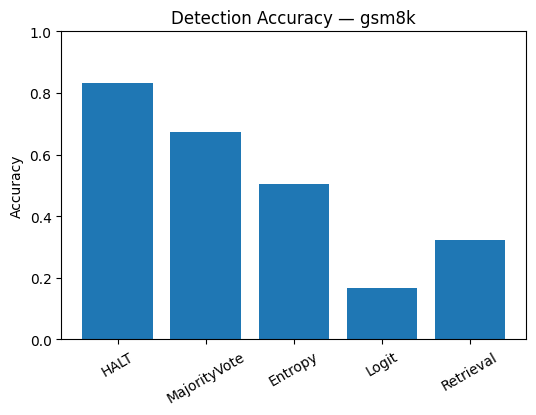

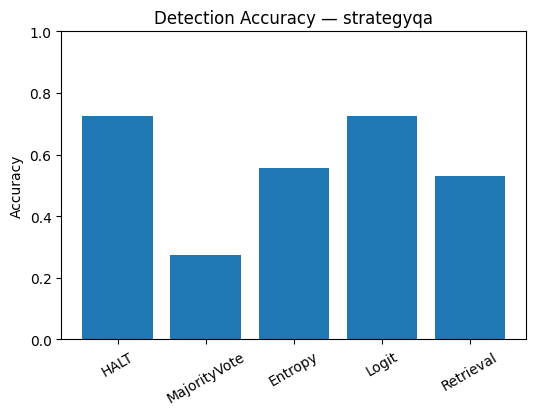

In [ ]:
#@title 📈 Bar Plot (Accuracy)
for task in results_df["Task"].unique():
    sub = results_df[results_df["Task"]==task]
    plt.figure(figsize=(6,4))
    plt.bar(sub["Method"], sub["Accuracy"])
    plt.title(f"Detection Accuracy — {task}")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.xticks(rotation=30)
    plt.show()


---
### Notes
- This notebook uses very light heuristics for math checking and NLI; feel free to swap in stronger components.
- For **real** numbers, set an OpenAI key and/or plug in your own model outputs (replace `outputs/raw_generations.json`).
- You can also skip generation: produce your model’s outputs offline as JSON in the same schema: `{task: [{question, gold, output, logprobs}]}`.